## IMPORTS

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
from glob import glob


sys.path.append('../../')
from utils import clustering_utils, bokeh_ui_utils, file_utils, rna_seq_utils

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/env

In [2]:
full_filtered_df = pd.read_csv('../../active_fastas/rna_seq.csv')
full_filtered_norm_df = rna_seq_utils.normalize_expression_per_gene(full_filtered_df)

num_genes = full_filtered_df.shape[0]
num_genes

23096

In [3]:
full_filtered_df.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
18310,YF00027341.t1,0.462041,0.875164,0.143750,0.539714,0.185134,0.216537,0.220078,0.336801,0.180725,0.306896,0.188017,0.449070,0.331633,0.214150,0.289748,0.353468,0.438837,0.471131
16564,YF00024729.t1,2.133190,3.020780,0.691341,1.817780,0.298709,1.403290,0.390789,1.470120,0.385301,1.494050,0.467708,1.643170,0.414534,0.923437,0.572161,0.715789,0.467047,0.747073
6323,YF00009100.t1,7.320810,5.885640,6.242230,5.958110,4.423370,5.288760,4.622110,5.150850,5.189860,4.884310,5.325360,4.556190,5.868030,5.257950,6.851890,6.103930,7.428460,6.527460
10169,YF00015324.t1,0.221642,0.279644,0.167145,0.181890,0.226254,0.107910,0.164227,0.251646,0.269477,0.320295,0.140148,0.247946,0.118078,0.172382,0.092980,0.100843,0.109354,0.093811
4616,YF00006459.t1,39.856700,38.598600,37.927300,41.899500,23.542000,38.572200,15.244000,30.902100,13.432300,27.693900,13.097700,24.588500,11.960700,23.947100,14.241400,24.971200,17.734500,23.997900
22660,YF00037593.t1,0.022696,0.078886,0.095016,0.087796,0.053962,0.079266,0.050447,0.061677,0.066349,0.108314,0.017260,0.061076,0.076229,0.052768,0.009453,0.038429,0.020078,0.028779
13543,YF00020324.t1,4.713690,2.610880,2.201090,2.830660,0.779279,1.989380,0.745451,2.168270,0.897612,1.333700,1.146010,1.858570,1.552050,1.842130,1.988010,1.769080,2.313320,2.287720
10510,YF00015816.t1,0.375087,0.111876,0.038388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044826,0.000000,0.000000,0.000000,0.049972,0.000000,0.000000,0.000000
1488,YF00001951.t1,0.072475,0.320062,0.070264,0.101960,0.147960,0.211693,0.053701,0.246842,0.105746,0.246889,0.137491,0.389194,0.069491,0.120777,0.030398,0.098909,0.064358,0.161041
11654,YF00017548.t1,5.504070,18.592700,6.536310,16.342600,6.222040,15.867600,8.762610,17.369100,13.885900,24.011700,15.610400,29.117100,13.602700,21.189400,10.200600,14.238700,8.674460,12.336600


In [4]:
averaged_full_filtered_norm_df = rna_seq_utils.ari_mean_df_of_duplicates(full_filtered_norm_df)

cycle_expression_conflict_df = averaged_full_filtered_norm_df.loc[
    (averaged_full_filtered_norm_df['000min'] > 0.9)
    &
    (averaged_full_filtered_norm_df['210min'] < 0.1)
    &
    (averaged_full_filtered_norm_df['240min'] < 0.1)
]

cycle_expression_conflict_df.to_csv('./cycle_expression_conflict.csv')

### LEIDEN CLUSTERING

In [5]:
phases = 'rna_seq'

In [6]:
metric = 'manhattan'
# metric='minkowski_3.0'

# resolution_param=0.050
resolution_param=0.005

n_neighbors = 3

dataset = 'rna_seq'

In [7]:
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_norm_df, 
    dataset,
    metric=metric, 
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [8]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./rna_seq_label_df_round_1.csv', index=False)

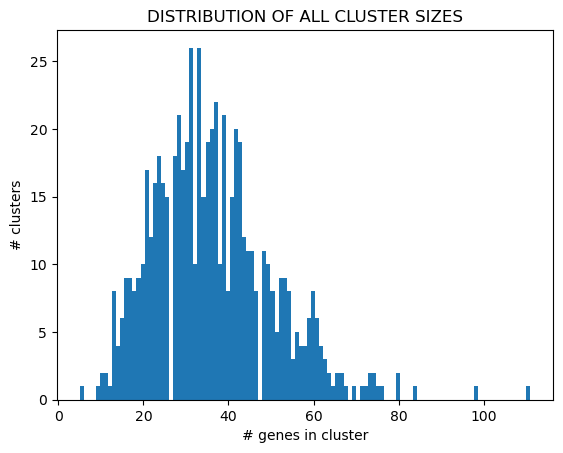

In [9]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

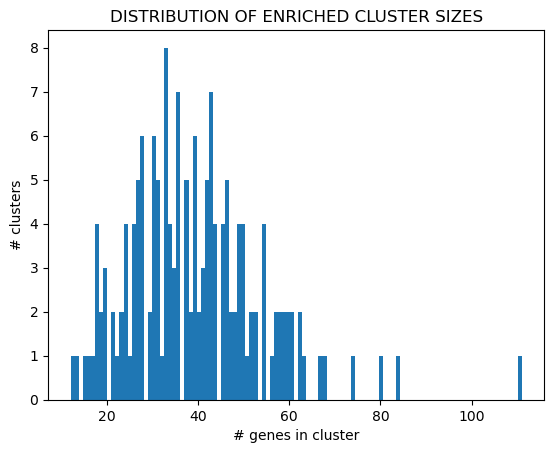

In [10]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [11]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.06323356891112435
                  modularity: 0.7379874399134001
                   nclusters: 637
           mean_cluster_size: 36.2574568288854
         median_cluster_size: 35.0
             sd_cluster_size: 14.094978178727745
          nenriched_clusters: 159
  mean_enriched_cluster_size: 39.23270440251572
median_enriched_cluster_size: 37.0
    sd_enriched_cluster_size: 14.658886573655204
     nenriched_cluster_genes: 6238
                    datetime: 2024-05-15 12:16:50.515072


In [12]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [13]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [14]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [15]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [16]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [17]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [18]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [19]:
yf_to_ttherm_map_df = pd.read_csv('../../new_raw_data/tgd2024/yf_ttherm_mapping_may2024.csv')
yf_to_ttherm_map_df.rename(columns={'TTHERM_ID': 'TTHERM_IDs', 'YF_ID': 'TTHERM_ID'},inplace=True)

In [20]:
import os

embedding_metric = 'manhattan'

In [21]:
full_filtered_norm_df.shape

(23096, 19)

In [22]:
leiden_label_df_round_1_arranged_sorted.shape

(23096, 2)

In [23]:
complete_annot.shape

(25987, 22)

In [24]:
dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['rna_seq', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'rna_seq', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, embedding_metric=embedding_metric, n_neighbors=n_neighbors, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:1332: UserWarning: The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.
relevant_annot: 22201 rows\merge: 23096 rows
  warnings.warn(f'The number of rows (genes) in the relevant annotation dataframe and the merged input dataframe are not equal. If you are using a new genome model, please rerun eggnog to ensure all annotations are populated.\nrelevant_annot: {relevant_annot.shape[0]} rows\merge: {merge.shape[0]} rows')
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

./plots/dashboard354_rna_seq_umap_manhattan_3nn_0.005rp.html


In [25]:
# dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['rna_seq', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

# p = bokeh_ui_utils.generate_and_save_mds(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'rna_seq', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, embedding_metric=embedding_metric, n_neighbors=n_neighbors, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

In [26]:
# (HH2A.1, HH2A.2, HH2B.1, HH2B.2, HH3, HH4.1, and HH4.2)
HHs = [
"TTHERM_00189170", "TTHERM_00143660", "TTHERM_00633360", "THERM_00283180", 
]

# (Figure 3A; CPD1, CPD2, and CPG3 and SMC2 and SMC4).
CPD_CPG_SMC = [
"TTHERM_00486070", "TTHERM_00392760", "TTHERM_00919690", "TTHERM_00812950", "TTHERM_0044640", 
]

# cyclin D family members, CYC4, CYC13, and CYC25
cyclin_D_family_members = [
"TTHERM_01043080", "TTHERM_01128530", "TTHERM_00717540",
]

# all cyclins
cyclins = [
'TTHERM_00196590',
'TTHERM_00433390',
'TTHERM_00526250',
'TTHERM_00962160',
'TTHERM_01128530',
'TTHERM_00189230',
'TTHERM_00425970',
'TTHERM_00780580',
'TTHERM_00693080',
'TTHERM_00827080',
'TTHERM_00698650',
'TTHERM_00079530',
'TTHERM_00624450',
'TTHERM_00784350',
'TTHERM_00933270',
'TTHERM_00732460',
'TTHERM_00842480',
'TTHERM_00717540',
'TTHERM_00066840',
'TTHERM_000576939',
'TTHERM_00082190',
'TTHERM_00649450',
'TTHERM_00180970',
'TTHERM_00726380',
'TTHERM_00013060',
'TTHERM_00049420',
'TTHERM_00294860',
'TTHERM_00535270',
'TTHERM_01043080',
'TTHERM_00192000',
'TTHERM_00194440',
'TTHERM_00293270',
'TTHERM_00332170',
'TTHERM_00940290',
]

cyc_subset = [
'TTHERM_00196590', # CYC1 
'TTHERM_00425970', # CYC15
'TTHERM_00624450', # CYC20
'TTHERM_00842480', # CYC24
'TTHERM_00194440', # CYC6
'TTHERM_00332170', # CYC8
]

all_cdks = [
'TTHERM_00411810', #	CDK1
'TTHERM_00318700', #	CDK10
'TTHERM_00576780', #	CDK11
'TTHERM_00267860', #	CDK13
'TTHERM_00394590', #	CDK14
'TTHERM_01035490', #	CDK15
'TTHERM_00624260', #	CDK16
'TTHERM_00066860', #	CDK17
'TTHERM_00784290', #	CDK18
'TTHERM_00339880', #	CDK19
'TTHERM_01347900', #	CDK20
'TTHERM_000837979', #	CDK21
'TTHERM_000937671', #	CDK22
'TTHERM_00011670', #	CDK3
'TTHERM_00286770', #	CDK4
'TTHERM_01080600', #	CDK5
'TTHERM_00837980', #	CDK6
'TTHERM_00133750', #	CDK7
'TTHERM_00717780', #	CDK8
'TTHERM_00185770', #	CDK9
'TTHERM_00483640', #	TCDK3
]

nucleic_acid_metabolic_process = [
'TTHERM_00046490',
'TTHERM_00535470',
'TTHERM_00312260',
'TTHERM_01079170',
'TTHERM_000378989',
'TTHERM_00825460',
'TTHERM_00298220',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00787360',
'TTHERM_00112560',
'TTHERM_00561799',
'TTHERM_00723610',
'TTHERM_00794250',
]

telomere_maintenance = [
'TTHERM_000378989',
'TTHERM_00433640',
'TTHERM_00112560',
'TTHERM_00561799',
]

# DECENT
mitotic_nuclear_division = [
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00118700',
'TTHERM_00079520',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00498210',
]

mitotic_cell_cycle = [
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00118700',
'TTHERM_00079520',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00498210',
]

chromosome_organization = [
'TTHERM_00088010',
'TTHERM_00307700',
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00189170',
'TTHERM_00790790',
'TTHERM_00316500',
'TTHERM_00143660',
'TTHERM_00633360',
'TTHERM_00283180',
'TTHERM_00316410',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00455130',
'TTHERM_000378989',
'TTHERM_00726370',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00787360',
'TTHERM_00112560',
'TTHERM_00561799',
]

DNA_repair = [
'TTHERM_00307700',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00312260',
'TTHERM_00316410',
'TTHERM_00439320',
'TTHERM_01050440',
'TTHERM_01079170',
'TTHERM_01106120',
'TTHERM_00726470',
'TTHERM_00455309',
'TTHERM_00825460',
'TTHERM_00726370',
'TTHERM_00142290',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00561799',
'TTHERM_00723610',
'TTHERM_00888060',
'TTHERM_00864890',
'TTHERM_00829440',
'TTHERM_00794250',
]

microtubule_cytoskeleton_organi = [
'TTHERM_00335970'
'TTHERM_00426160'
'TTHERM_01220340'
'TTHERM_00522990'
'TTHERM_00338260'
'TTHERM_000727749'
'TTHERM_000123789'
'TTHERM_000161298'
'TTHERM_00030040'
'TTHERM_000357129'
'TTHERM_00046500'
'TTHERM_000488189'
'TTHERM_000706399'
'TTHERM_00088040'
'TTHERM_00133700'
'TTHERM_00266668'
'TTHERM_00346790'
'TTHERM_00452020'
'TTHERM_00493000'
'TTHERM_00755750'
'TTHERM_00842510'
'TTHERM_00992710'
]

# all MCMs
all_MCMs = [
'TTHERM_00554270',
'TTHERM_00092850',
'TTHERM_00277550',
'TTHERM_00069420',
'TTHERM_00448570',
'TTHERM_00011740',
'TTHERM_01031060',
'TTHERM_00703910',
'TTHERM_01207610',
]

MCM_subset = ['YF00026324.1', 'YF00025215.1', 'YF00018584.1', 'YF00012156.1']
# YF00026324, YF00025215, YF00018584, YF00012156
# MCM5, MCM6, MCM3, MCM2

mucocyst_cluster = [
'YF00036312.t1',
'YF00012829.t1',
'YF00000889.t1',
'TTHERM_00527180',
'TTHERM_00335830',
'YF00012830.t1',
'YF00009126.t1',
'YF00005954.t1',
'YF00005804.t1',
'TTHERM_01055600',
'TTHERM_00624720',
] # TTHERM_00630470: mucocyst gene with drastically different expression profile

histones = ['TTHERM_00146340', 'TTHERM_00446570', 'TTHERM_00498190', 'TTHERM_00189170', 'TTHERM_00189180', 'TTHERM_00016170', 'TTHERM_00016200', 'TTHERM_00790790', 'TTHERM_00316500', 'TTHERM_00143660', 'TTHERM_01079200', 'TTHERM_00633360', 'TTHERM_00283180', 'TTHERM_00354710', 'TTHERM_00474790', 'TTHERM_00852840', 'TTHERM_01194650']

In [27]:
gene_lists = {}
gene_lists = {
'HHs': HHs,
'CPD_CPG_SMC': CPD_CPG_SMC,
'cyclin_D_family_members': cyclin_D_family_members,
'cyclins': cyclins,
'cyc_subset': cyc_subset,
'all_cdks': all_cdks,
'nucleic_acid_metabolic_process': nucleic_acid_metabolic_process,
'telomere_maintenance': telomere_maintenance,
'mitotic_nuclear_division': mitotic_nuclear_division,
'mitotic_cell_cycle': mitotic_cell_cycle,
'chromosome_organization': chromosome_organization,
'DNA_repair': DNA_repair,
'microtubule_cytoskeleton_organi': microtubule_cytoskeleton_organi,
'all_MCMs': all_MCMs,
'MCM_subset': MCM_subset,
'mucocyst_cluster': mucocyst_cluster,
'histones' : histones,
}

In [28]:
xls_files = glob('../../new_raw_data/rna_seq_processed/xls_files/*.xls')
sorted(xls_files)

['../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s01.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s02.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s03.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s04.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s05.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s06.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s07.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s08.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s09.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s10.xls']

In [29]:
for xls_file in xls_files:
    excel_file = pd.read_excel(xls_file, sheet_name=None)
    for sheet_name, df in excel_file.items():
        target_ids = []
        gene_cluster_assignments_mode_only = None

        first_column = list(df.iloc[:, 0].values)

        if sheet_name in gene_lists:
            name_num = 0
            new_sheet_name = sheet_name
            while new_sheet_name in gene_lists:
                name_num += 1
                new_sheet_name = f'{sheet_name}_{name_num}'
            print(f'WARNING: DUPLICATE GENE LIST NAME: \'{sheet_name}\'. RENAMING TO \'{new_sheet_name}\'.')
            sheet_name = new_sheet_name

        gene_lists[sheet_name] = first_column

In [30]:
fraction_threshold = 0.1

clustering_utils.multi_fraction_max_same_cluster_genes(gene_lists, leiden_label_df_round_1_arranged_sorted, fraction_threshold=fraction_threshold, print_mode=True)

GENE_LIST: HHs
TTHERM_00189170
TTHERM_00633360
THERM_00283180
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: CPD_CPG_SMC
TTHERM_00919690
TTHERM_0044640
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: cyclin_D_family_members
TTHERM_00717540
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: cyclins
TTHERM_00196590
TTHERM_00189230
TTHERM_00780580
TTHERM_00693080
TTHERM_00698650
TTHERM_00933270
TTHERM_00732460
TTHERM_00717540
TTHERM_000576939
TTHERM_00082190
TTHERM_00013060
TTHERM_00535270
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: cyc_subset
TTHERM_00196590
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: all_cdks
TTHERM_00576780
TTHERM_00624260
TTHERM_000937671
TTHERM_01080600
TTHERM_00837980
TTHERM_00717780
TTHERM_00483640
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: nucleic_acid_metabolic_process
TTHERM_00046490
TTHERM_000378989
TTHERM_00433640
TTHERM_00112560
T

In [31]:
','.join(cyclins)

'TTHERM_00196590,TTHERM_00433390,TTHERM_00526250,TTHERM_00962160,TTHERM_01128530,TTHERM_00189230,TTHERM_00425970,TTHERM_00780580,TTHERM_00693080,TTHERM_00827080,TTHERM_00698650,TTHERM_00079530,TTHERM_00624450,TTHERM_00784350,TTHERM_00933270,TTHERM_00732460,TTHERM_00842480,TTHERM_00717540,TTHERM_00066840,TTHERM_000576939,TTHERM_00082190,TTHERM_00649450,TTHERM_00180970,TTHERM_00726380,TTHERM_00013060,TTHERM_00049420,TTHERM_00294860,TTHERM_00535270,TTHERM_01043080,TTHERM_00192000,TTHERM_00194440,TTHERM_00293270,TTHERM_00332170,TTHERM_00940290'